# Parameter Inference and Calibration: Linking UER to GDP

View target demand as input to the model (instead of a stylized sinusoidal business cycle). 

I see two possible options:
1. GDP growth in line with Okun's Law specifically for unemployment - a 1% change in GDP: 0.03-0.05% change in UER
2. Growth in target demand


In [ ]:
# Import packages
from abm_funs import *
from plot_funs import *
import numpy as np
import pandas as pd
import random as random
import matplotlib.pyplot as plt
import tempfile
import pyabc
from scipy.stats import pearsonr, linregress
from pyabc.visualization import plot_kde_matrix, plot_kde_1d
import math as math
from pyabc.transition import MultivariateNormalTransition
import seaborn as sns
#from IPython.display import display
#from PIL import Image
#from pstats import SortKey
import datetime
from collate_macro_vars import *
import csv
#from dtaidistance import dtw
from functools import partial

rng = np.random.default_rng()
test_fun()

import os
print(os.cpu_count()) 

calib = True
save = True

NEW Function import successful
192


smoothing vac_df
220


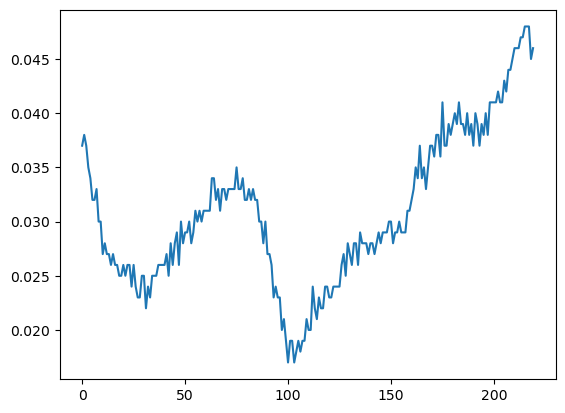

In [19]:

# Macro observations
observation = macro_observations.loc[(macro_observations['DATE'] >= calib_date[0]) & (macro_observations['DATE'] <= calib_date[1])].dropna(subset=["UNRATE", "VACRATE"]).reset_index()
# Load US_input data
A = pd.read_csv("dRC_Replication/data/occupational_mobility_network.csv", header=None)
employment = round(pd.read_csv("dRC_Replication/data/ipums_employment_2016.csv", header = 0).iloc[:, [4]]/10000)
# Crude approximation using avg unemployment rate of ~5% - should aim for occupation-specific unemployment rates
unemployment = round(employment*(0.05/0.95))
# Less crude approximation using avg vacancy rate - should still aim for occupation-specific vacancy rates
vac_rate_base = pd.read_csv("dRC_Replication/data/vacancy_rateDec2000.csv").iloc[:, 2].mean()/100
vacancies = round(employment*vac_rate_base/(1-vac_rate_base))
# Needs input data...
demand_target = employment + vacancies
wages = pd.read_csv("dRC_Replication/data/ipums_variables.csv")[['median_earnings']]
occ_ids = pd.read_csv("dRC_Replication/data/ipums_variables.csv")[['id', 'acs_occ_code']]
gend_share = pd.read_csv("data/ipums_variables_w_gender.csv")[['women_pct']]
mod_data =  {"A": A, "employment": employment, 
             'unemployment':unemployment, 'vacancies':vacancies, 
             'demand_target': demand_target, 'wages': wages, 'gend_share': gend_share}

###################################
# Initialise the model
##################################
net_temp, vacs = initialise(len(mod_data['A']), mod_data['employment'].to_numpy(), mod_data['unemployment'].to_numpy(), mod_data['vacancies'].to_numpy(), mod_data['demand_target'].to_numpy(), mod_data['A'], mod_data['wages'].to_numpy(), mod_data['gend_share'].to_numpy(), 0, 0)

# observation = macro_observations.loc[(macro_observations['DATE'] >= calib_date[0]) & (macro_observations['DATE'] <= calib_date[1])].dropna(subset = ["UNRATE", "VACRATE"]).reset_index()
# Load calibrated parameters from CSV
param_df = pd.read_csv("output_16_05/calibrated_params_all.csv")
# Sort by Timestamp in descending order
param_df = param_df.sort_values(by='Timestamp', ascending=False)

params = {'mod_data': mod_data, 
            'net_temp': net_temp,
            'vacs': vacs, 
            'time_steps': len(gdp_dat),
            'delay': 100,
            'gdp_data': gdp_dat}

# Shorten vac_df to the same length as gdp_dat using a moving average (if needed)   
vac_df = observation['VACRATE'].to_numpy()
if len(vac_df) > len(gdp_dat):
    print("smoothing vac_df")
    # Apply moving average with window to smooth and match length
    window = len(vac_df) // len(gdp_dat)
    vac_dat = pd.Series(vac_df).rolling(window=window, min_periods=1).mean()[window-1::window].reset_index(drop=True)
    vac_dat = vac_dat[:len(gdp_dat)]
else:
    vac_dat = vac_df
    
print(len(vac_dat))
plt.plot(vac_dat, label="Vacancy Rate (smoothed)")


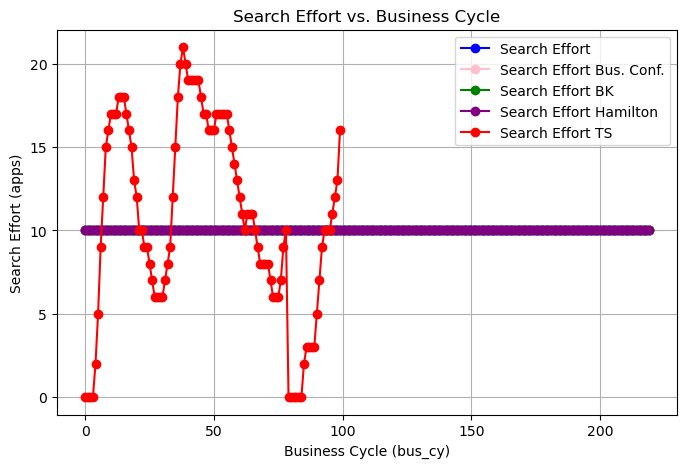

In [20]:
search_effort_dat = pd.read_csv("data/quarterly_search_ts.csv")
search_effort_dat['DATE'] = pd.to_datetime(search_effort_dat['year'].astype(str) + '-' + (search_effort_dat['quarter'] * 3 - 2).astype(str) + '-01')
search_effort_np = np.array(search_effort_dat['value_smooth'])
search_effort_np = search_effort_np/search_effort_np.mean()

# Define a range of bus_cy values  # Generates 100 values from 0 to 1
search_effort_values = [search_effort(0, b, False, 0.1) for b in gdp_dat]  # Apply function
search_effort_bus_conf_values = [search_effort(0, b, False, 0.1) for b in bus_conf_dat]  # Apply function
search_effort_bk_values = [search_effort(0, b, False, 0.1) for b in gdp_dat_bk]  # Apply function
search_effort_hamilton_values = [search_effort(0, b, False, 0.1) for b in gdp_dat_hamilton]  # Apply function
# def search_effort_ts(t_unemp, se):
#     apps = max(0, round(10 - 100*(1-se)))
#     # if discouraged:
#     #     apps = round(a_stable/((t_unemp)**2 + 1)) + 1
#     return apps
search_effort_values_dyn = [search_effort_ts(0, b) for b in search_effort_np]

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(range(len(search_effort_values)), search_effort_values, marker='o', linestyle='-', color='b', label="Search Effort")
plt.plot(range(len(search_effort_bus_conf_values)), search_effort_bus_conf_values, marker='o', linestyle='-', color='pink', label="Search Effort Bus. Conf.")
plt.plot(range(len(search_effort_bk_values)), search_effort_bk_values, marker='o', linestyle='-', color='g', label="Search Effort BK")
plt.plot(range(len(search_effort_hamilton_values)), search_effort_hamilton_values, marker='o', linestyle='-', color='purple', label="Search Effort Hamilton")

plt.plot(range(len(search_effort_values_dyn)), search_effort_values_dyn, marker='o', linestyle='-', color='r', label="Search Effort TS")
plt.xlabel("Business Cycle (bus_cy)")
plt.ylabel("Search Effort (apps)")
plt.title("Search Effort vs. Business Cycle")
plt.legend()
plt.grid(True)
plt.show()



{'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'y': [10, 10, 13, 16, 19, 22, 25, 28, 22, 14, 4, 1, 1, 1, 1]}
{'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'y': [10, 10, 12, 14, 16, 18, 20, 22, 19, 16, 11, 6, 1, 1, 1]}
{'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'y': [10, 10, 11, 12, 13, 14, 15, 16, 15, 14, 13, 12, 10, 9, 7]}
{'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'y': [10, 10, 10, 11, 12, 12, 12, 13, 13, 13, 12, 12, 12, 11, 10]}
{'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'y': [10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 10, 10, 10]}


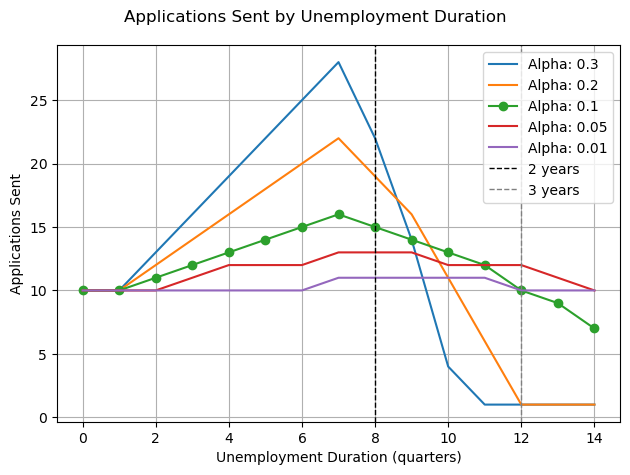

{'Alpha: 0.3': {'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'y': [10, 10, 13, 16, 19, 22, 25, 28, 22, 14, 4, 1, 1, 1, 1]}, 'Alpha: 0.2': {'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'y': [10, 10, 12, 14, 16, 18, 20, 22, 19, 16, 11, 6, 1, 1, 1]}, 'Alpha: 0.1': {'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'y': [10, 10, 11, 12, 13, 14, 15, 16, 15, 14, 13, 12, 10, 9, 7]}, 'Alpha: 0.05': {'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'y': [10, 10, 10, 11, 12, 12, 12, 13, 13, 13, 12, 12, 12, 11, 10]}, 'Alpha: 0.01': {'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'y': [10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 10, 10, 10]}}


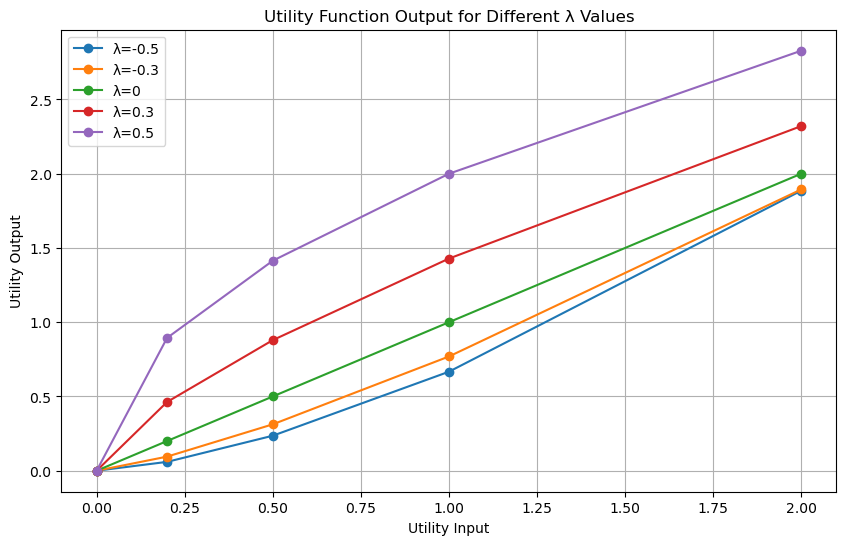

In [ ]:
series_dict = {}
for i, a in enumerate([0.3, 0.2, 0.1, 0.05, 0.01]):
    efforts = []
    for t_unemp in range(15):
        apps = search_effort(t_unemp, 1, True, a)
        efforts.append(apps)

    series_dict[f"Alpha: {a}"] = {
        "x": list(range(0, len(efforts))),
        "y": efforts
        }

for i, a in series_dict.items():
    if i == 'Alpha: 0.1':
        plt.plot(a['x'], a['y'],marker='o', linestyle='-', label=i)
    else:
        plt.plot(a['x'], a['y'],  linestyle='-', label=i)
    plt.xlabel("Unemployment Duration (quarters)")
    plt.ylabel("Applications Sent")

   
plt.axvline(x=8, color='black', linestyle='--', linewidth=1, label='2 years')
plt.axvline(x=12, color='grey', linestyle='--', linewidth=1, label='3 years')
plt.legend(loc='upper right')
plt.grid(True)
plt.suptitle("Applications Sent by Unemployment Duration")
plt.tight_layout()
plt.show()

print(series_dict)
def utility_fun(lambda_param, utility):
    if lambda_param == 1:
        return(np.log(utility))
    else:
        return((utility**(1-lambda_param))/(1-lambda_param))

lambdas = [-0.5, -0.3, 0, 0.3, 0.5]
utilities = [0, 0.2, 0.5, 1, 2]

plt.figure(figsize=(10, 6))

for lambda_p in lambdas:
    utility_outputs = []
    for utility in utilities:
        utility_outputs.append(utility_fun(lambda_p, utility))
    plt.plot(utilities, utility_outputs, marker='o', label=f'λ={lambda_p}')

plt.xlabel('Utility Input')
plt.ylabel('Utility Output') 
plt.title('Utility Function Output for Different λ Values')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
####################
# Model Run ########
####################
def run_single_local( #behav_spec, 
                    d_u, 
                    #d_v,
                    gamma_u,
                    #gamma_v,
                    otj,
                    cyc_otj, 
                    cyc_ue, 
                    disc,
                    mod_data = mod_data, 
                    net_temp = net_temp, 
                    vacs = vacs, 
                    time_steps = len(gdp_dat), # set equal to length of gdp_data
                    delay = 100,
                    gdp_data = gdp_dat,
                    bus_confidence_dat = gdp_dat,
                    simple_res = False, 
                    vac_data = vac_dat):
    
    """ Runs the model once
    Argsuments:
       behav_spec: whether or not to run the behavioural model
       data: data required of initialise function  
       time_steps: Number of time steps for single model run
       d_u: parameter input to separation probability
       d_v: parameter input to vacancy opening probability

    Returns:
       dataframe of model run results
    """
    # Records variables of interest for plotting
    # Initialise deepcopy occupational mobility network
    #print(behav_spec)
    record = np.empty((0, 7))
    #print(parameter['vacs'])
    vacs_temp = deepcopy(vacs)
    net = deepcopy(net_temp)
    seekers_rec = []
    time_steps = time_steps + delay

    for t in range(time_steps):
        #if t == 1:
            #print(behav_spec)
        if t <= delay:
            curr_bus_cy = 1
            bus_conf = 1
            ue_bc = 1
            vr_t = 0.03
        if t > delay:
            curr_bus_cy = gdp_data[t-delay]
            bus_conf = bus_confidence_dat[t-delay]
            ue_bc = curr_bus_cy
            vr_t = vac_data[t-delay]
        if not cyc_ue:
            ue_bc = 1
        # search_eff_curr = search_eff_ts[t]
        # Ensure number of workers in economy has not changed
        #tic = time.process_time()
        emp_seekers = 0
        unemp_seekers = 0
        u_apps = 0
        u_searchers = 0
        for occ in net:
            ### APPLICATIONS
            # Questions to verify:
            # - CANNOT be fired and apply in same time step ie. time_unemployed > 0
            # - CAN be rejected and apply in the same time step - no protected attribute
            # isolate list of vacancies in economy that are relevant to the occupation
            # - avoids selecting in each search_and_apply application
            r_vacs = [vac for vac in vacs_temp if occ.list_of_neigh_bool[vac.occupation_id]]          
    
            for u in occ.list_of_unemployed:
                unemp_seekers += 1
                # this one if only using simple scaling factor for the search effort
                u.search_and_apply(net, r_vacs, disc, ue_bc, 0.1)
                # use the following if we wish to incorporate the entire TS of search effort
                #u.search_and_apply(net, r_vacs, behav_spec, search_eff_curr)
            
            if otj:
                # For both models, a mean of 40% of employed workers are searching for new jobs
                # This fluctuates with the business cycle in the behavioural model in line with gdp
                if cyc_otj:
                    search_scaling = curr_bus_cy*0.07
                # Static mean in the non-behavioural model
                else:
                    search_scaling = 0.07
                for e in random.sample(occ.list_of_employed, int(search_scaling*len(occ.list_of_employed))):
                    emp_seekers += 1
                    e.emp_search_and_apply(net, r_vacs, disc)

            u_apps += sum(wrkr.apps_sent for wrkr in occ.list_of_unemployed if  wrkr.apps_sent is not None)
            u_searchers += len(occ.list_of_unemployed)

            ### SEPARATIONS
            try:
                occ.separate_workers(d_u, gamma_u, curr_bus_cy)
            except Exception as e:
                return np.inf


        ### HIRING
        # Ordering of hiring randomised to ensure list order does not matter in filling vacancies...
        # Possibly still introduces some bias...this seems to be where the "multiple offer" challenge Maria mentioned comes from
        # ....might be better to do this using an unordered set?
        for v_open in sorted(vacs_temp,key=lambda _: random.random()):
            # Removes any applicants that have already been hired in another vacancy
            v_open.applicants[:] = [app for app in v_open.applicants if not(app.hired)]
            v_open.time_open += 1
            if len(v_open.applicants) > 0:
                v_open.hire(net)
                v_open.filled = True
                #vacs.remove(v_open)
                assert(len(v_open.applicants) == 0)
            else:
                pass

        vacs_temp = [v for v in vacs_temp if not(v.filled)] 

        # # Reset counters for record in time t
        empl = 0 
        unemp = 0
        n_ltue = 0
        # curr_demand = 0
        t_demand = 0

        ### OPEN VACANCIES
        # Update vacancies after all shifts have taken place
        # Could consider making this a function of the class itself?
        for occ in net:
            u_rel_wage = sum(wrkr.ue_rel_wage for wrkr in occ.list_of_employed if wrkr.hired and wrkr.ue_rel_wage is not None)
            e_rel_wage = sum(wrkr.ee_rel_wage for wrkr in occ.list_of_employed if wrkr.hired and wrkr.ee_rel_wage is not None)
            ue = len([w for w in occ.list_of_employed if w.hired and w.ue_rel_wage is not None])
            ee = len([w for w in occ.list_of_employed if w.hired and w.ee_rel_wage is not None])
            # Update time_unemployed and long-term unemployed status of unemployed workers
            # Remove protected "hired" attribute of employed workers
            occ.update_workers()
            # Assert that all unemployed people have spent 1 or more time periods unemployed
            assert(sum([worker.time_unemployed <= 0 for worker in occ.list_of_unemployed]) == 0)
            # Assert that all employed people have spent 0 time periods unemployed
            assert(sum([worker.time_unemployed <= 0 for worker in occ.list_of_employed]) == len(occ.list_of_employed))
            emp = len(occ.list_of_employed)
            curr_vacs = len([v_open for v_open in vacs_temp if v_open.occupation_id == occ.occupation_id])
            occ.current_demand = (curr_vacs + emp)
            # If real-world vacancy rate is greater than the current vacancy rate, then we create new vacancies 
            vac_prob = max(0, vr_t - (curr_vacs/(occ.current_demand + 1)))
            # vac_prob = d_v + ((gamma_v * max(0, occ.target_demand*(bus_conf) - occ.current_demand)) / (emp + 1))
            vacs_create = int(np.random.binomial(emp, vac_prob))

            #vacs_create = emp*int(vac_prob) + int(np.random.binomial(emp, vac_prob%1))
            for v in range(vacs_create):
                vacs_temp.append(vac(occ.occupation_id, [], occ.wage, False, 0))
            empl += len(occ.list_of_employed) 
            unemp += len(occ.list_of_unemployed)
            n_ltue += sum(wrkr.longterm_unemp for wrkr in occ.list_of_unemployed)
            t_demand += occ.target_demand

        ### UPDATE INDICATOR RECORD
        record = np.append(record, 
                       np.array([[t+1, empl, unemp, empl + unemp, len(vacs_temp), n_ltue, t_demand]]), axis=0)
        # clean_record = pd.DataFrame(record[delay:])
        # clean_record.columns =['Time Step', 'Employment', 'Unemployment', 'Workers', 'Vacancies', 'LT Unemployed Persons', 'Target_Demand']
        # clean_record['UER'] = clean_record['Unemployment']/clean_record['Workers']
        # clean_record['VACRATE'] = clean_record['Vacancies']/clean_record['Target_Demand']
        #data = clean_record[['Time Step', 'UER', 'VACRATE']]
    data = {'UER': np.array(record[delay:,2]/record[delay:,3]), 
            'VACRATE': np.array(record[delay:,4]/(record[delay:,4] + record[delay:,1] + 1))}
    #     seekers_rec.append([t+1, unemp_seekers, u_apps])


    # record_temp_df = pd.DataFrame(record, columns=['Time Step', 'Occupation', 'Employment', 'Unemployment', 'Workers', 'Vacancies', 'LT Unemployed Persons', 'Current_Demand', 'Target_Demand', 'Employed Seekers', 'Unemployed Seekers', 'Total_Wages', 'U_Rel_Wage', 'E_Rel_Wage', 'UE_Transitions', 'EE_Transitions'])
    # record_df = record_temp_df[record_temp_df['Time Step'] > delay]
    # grouped = record_df.groupby('Time Step').sum().reset_index()

    # grouped['UER'] = grouped['Unemployment'] / grouped['Workers']
    # grouped['U_REL_WAGE_MEAN'] = grouped['U_Rel_Wage'] / grouped['UE_Transitions']
    # grouped['E_REL_WAGE_MEAN'] = grouped['E_Rel_Wage'] / grouped['EE_Transitions']
    # grouped['UE_Trans_Rate'] = grouped['UE_Transitions'] / grouped['Workers']
    # grouped['EE_Trans_Rate'] = grouped['EE_Transitions'] / grouped['Workers']
    # grouped['VACRATE'] = grouped['Vacancies'] / (grouped['Vacancies'] + grouped['Employment'])

    #data = {'UER': np.array(grouped['UER']), 'VACRATE': np.array(grouped['VACRATE'])}


    #seekers_rec = pd.DataFrame(seekers_rec, columns=['Time Step', 'Unemployed Seekers', 'Applications Sent'])
    #seekers_rec = seekers_rec[seekers_rec['Time Step'] > delay]

    if simple_res:
        return data
    else:
        return data
        #return record_df, grouped, net, data, seekers_rec

#########################################
# Wrapper for pyabc ########
#########################################
def pyabc_run_single(parameter):     
    res = run_single_local(**parameter)
    return res 

run_single_local(
    d_u = 0.01, 
    #d_v = 0.1,
    gamma_u = 0.01,
    #gamma_v = 0.1,
    otj = True,
    cyc_otj = True, 
    cyc_ue = True, 
    disc = False,
    mod_data = mod_data, 
    net_temp = net_temp, 
    vacs = vacs, 
    time_steps = len(gdp_dat), # set equal to length of gdp_data
    delay = 100,
    gdp_data = gdp_dat,
    bus_confidence_dat = gdp_dat,
    simple_res = True, 
    vac_data = vac_dat
)

{'UER': array([0.01567505, 0.02187692, 0.02371703, 0.02242214, 0.02582976,
        0.02664758, 0.02807878, 0.02964629, 0.03080488, 0.03652968,
        0.03782458, 0.03918762, 0.03693859, 0.03727936, 0.03959654,
        0.04354938, 0.04429905, 0.04661623, 0.04934233, 0.05165951,
        0.05131875, 0.05390854, 0.05390854, 0.05465822, 0.05459006,
        0.05690724, 0.05833844, 0.05956519, 0.06106454, 0.0656989 ,
        0.06665304, 0.06747086, 0.0671301 , 0.06678934, 0.07026511,
        0.0712874 , 0.0714237 , 0.07176447, 0.07081033, 0.07081033,
        0.07115109, 0.07237784, 0.07087848, 0.0727186 , 0.07258229,
        0.07312751, 0.07319567, 0.07319567, 0.07442241, 0.07258229,
        0.07183262, 0.07156001, 0.07237784, 0.06822054, 0.07006066,
        0.06931098, 0.06835685, 0.06760717, 0.06726641, 0.06563075,
        0.06290465, 0.06201867, 0.06195052, 0.05990595, 0.05799768,
        0.05643018, 0.05506713, 0.05404484, 0.05493083, 0.05493083,
        0.05220473, 0.05213658, 0.0527499

In [23]:
def harmonise_length(x, y):
    """
    GDP data used to calibrate has lower periodicity than the UER and VACRATE used for calibration. The following linearly interpolates the simulated output to match the frequency of the UER and Vacancy Rate data
    Harmonises the length of the time series to compare to each other. 
        
    Args:
        x (dict): Simulated data with keys "UER" and "VACRATE".
        y (dict): Real-world data with keys "UER" and "VACRATE".
    
    Returns:
        expanded_format: x expanded via linear interpolation - now of same length as y (observed time series of UER and vacancy rate)
    """
    expanded_format = pd.DataFrame({
        col: np.interp(
            np.linspace(0, len(x[col]) - 1, len(y[col])),
            np.linspace(0, len(x[col]) - 1, len(x[col])),
            x[col]
            )
            for col in x.keys()
            })
    return expanded_format

def distance_weighted(x, y): #weight_shape=0, weight_mean=1):
    x_ = harmonise_length(x, y)
    
    # Normalized SSE using variance
    uer_sse = np.sum((x_["UER"] - y["UER"])**2) / np.var(y["UER"])
    #vacrate_sse = np.sum((x_["VACRATE"] - y["VACRATE"])**2) / np.var(y["VACRATE"])

    # Weighted combination
    dist = (np.sqrt(uer_sse))
    return dist


In [ ]:
calib_list = {
    "nonbehav": {"otj": False, # has been run
                           "cyc_otj": False, 
                           "cyc_ue": False, 
                           "disc": False,
                           "bus_confidence_dat": gdp_dat},
              "otj_nonbehav": {"otj": True, # has been run
                           "cyc_otj": False, 
                           "cyc_ue": False, 
                           "disc": False, 
                           "bus_confidence_dat": gdp_dat},
    #           "otj_cyclical_e": {"otj": True,
    #                        "cyc_otj": True, 
    #                        "cyc_ue": False, 
    #                        "disc": False,
    #                        "bus_confidence_dat": gdp_dat},
            #   "otj_cyclical_ue ": {"otj": True,
            #                "cyc_otj": False, 
            #                "cyc_ue": True, 
            #                "disc": False},
            #   "otj_cyclical_e_ue": {"otj": True,
            #                "cyc_otj": True, 
            #                "cyc_ue": True, 
            #                "disc": False},
              "otj_cyclical_e_disc": {"otj": True,
                           "cyc_otj": True, 
                           "cyc_ue": False, 
                           "disc": True,
                           "vac_data": vac_dat,
                           'simple_res': True,
                           "bus_confidence_dat": gdp_dat,
                           'delay': 20},
              # "otj_cyclical_ue_disc": {"otj": True,
              #              "cyc_otj": False, 
              #              "cyc_ue": True, 
              #              "disc": True},
              # "otj_cyclical_e_ue_disc": {"otj": True,
              #              "cyc_otj": True, 
              #              "cyc_ue": True, 
              #              "disc": True}
              "otj_disc": {"otj": True,
                            "cyc_otj": False, 
                            "cyc_ue": False, 
                            "disc": True,
                            "vac_data": vac_dat,
                            'simple_res': True,
                            "bus_confidence_dat": gdp_dat,
                            'delay': 20}
            }

In [ ]:
observation = macro_observations.loc[(macro_observations['DATE'] >= calib_date[0]) & (macro_observations['DATE'] <= calib_date[1])].dropna(subset = ["UNRATE", "VACRATE"]).reset_index()

if calib:
    prior = pyabc.Distribution(d_u = pyabc.RV("uniform", 0.00001, 0.2),
                        #d_v = pyabc.RV("uniform", 0.00001, 0.06),
                        gamma_u = pyabc.RV("uniform", 0.00001, 0.7))
                        #gamma_v = pyabc.RV("uniform", 0.00001, 1)) 
    
    
    # Define possible distance functions and behav_spec values
    #behav_spec_values = [False, True]

    # CSV filename
    csv_filename = os.path.expanduser(f"output_06_06/calibrated_params_all.csv")

    # Ensure CSV file starts with headers
    if not os.path.exists(csv_filename):
        with open(csv_filename, "w", newline="") as file:
            writer = csv.writer(file)
            writer.writerow(["Parameter", "Value", "otj", "cyc_otj", "cyc_ue", "disc", "Timestamp"])


    for name, temp_params in calib_list.items():
        print(f"Running calibration for {name}")

        # Create a new version with different default values
        temp_run = partial(run_single_local, **temp_params)
            
        #########################################
        # Wrapper for pyabc ########
        #########################################
        def pyabc_run_single(parameter):     
            res = temp_run(**parameter)
            return res

        # Set up ABC calibration
        calib_sampler = pyabc.sampler.MulticoreEvalParallelSampler(n_procs=100)
        
        abc = pyabc.ABCSMC(pyabc_run_single, prior, distance_weighted, population_size=100, sampler=calib_sampler)

        db_path = os.path.join(tempfile.gettempdir(), f"test_{name}.db")
        # The following creates the "reference" values from the observed data - I pull the non-recession or expansion period from 2010-2019.
        #observation = macro_observations.loc[(macro_observations['DATE'] >= calib_date[0]) & (macro_observations['DATE'] <= calib_date[1])].dropna(subset = ["UNRATE", "VACRATE"]).reset_index()

        data = {'UER': np.array(observation['UER']),
            'VACRATE': np.array(observation['VACRATE'])}
    
        abc.new("sqlite:///" + db_path, data)

        history = abc.run(minimum_epsilon=0.1, max_nr_populations=15)

        # Extract parameter estimates
        df, w = history.get_distribution(t=history.max_t)
        final_params = {
            "d_u": np.sum(df["d_u"] * w),
            #"d_v": np.sum(df["d_v"] * w),
            "gamma_u": np.sum(df["gamma_u"] * w),
            #"gamma_v": np.sum(df["gamma_v"] * w),
        }

        # Save parameter estimates to CSV
        with open(csv_filename, "a", newline="") as file:
            writer = csv.writer(file)
            for param, value in final_params.items():
                writer.writerow([param, value, temp_params['otj'], temp_params['cyc_otj'], temp_params['cyc_ue'], temp_params['disc'], datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")])

        # Generate and save plots
        plot_directory = os.path.expanduser("output_06_06/")
        os.makedirs(plot_directory, exist_ok=True)
        plot_filename_base = plot_directory + f"calibration_{name}"
        
        # KDE Matrix
        plt.figure()
        plot_kde_matrix(
            df, 
            w, 
            limits={"d_u": (0.00001, 0.2),
                     #"d_v": (0.00001, 0.1),
                       "gamma_u": (0.00001, 0.7)},
                        # "gamma_v": (0.00001, 1)}, 
            refval=final_params, 
            names={"d_u": r"$\delta_u$", 
                   #"d_v": r"$\delta_v$", 
                   "gamma_u": r"$\gamma_u$"} 
                   #"gamma_v": r"$\gamma_v$"}
        )
        plt.savefig(f"{plot_filename_base}_kde_matrix.png", bbox_inches='tight', pad_inches=0.5)
        plt.close()

        # Joint KDE Plot for d_u and gamma_u
        sns.jointplot(x="d_u", y="gamma_u", kind="kde", data=df, weights=w, cmap="viridis_r", marginal_kws={'fill': True})
        plt.xlabel(r'$\delta_u$')
        plt.ylabel(r'$\gamma_u$')
        plt.axvline(x=np.sum(df["d_u"] * w), color="green", linestyle='dashed')
        plt.axhline(y=np.sum(df["gamma_u"] * w), color="green", linestyle='dashed')
        plt.suptitle(r"Kernel Density Estimate: $\delta_u$, $\gamma_u$", y=1.02)
        plt.savefig(f"{plot_filename_base}_joint_delta.png", bbox_inches='tight', pad_inches=0.5)
        plt.close()

        # Simulation Results Plot
        fig, axes = plt.subplots(2, 1, sharex=True)
        fig.set_size_inches(8, 12)
        n = 15  # Number of samples to plot from each category
        alpha = 0.5

        sum_stats = history.get_weighted_sum_stats_for_model(m=0, t=history.max_t)
        calib_date = [pd.to_datetime(calib_date[0]), pd.to_datetime(calib_date[1])]
        buffer = pd.DateOffset(years=1)

        for stored in sum_stats[1][:n]:
            stored_ = harmonise_length(stored, observation)
            date_range = pd.date_range(start=calib_date[0], end=calib_date[1], periods=len(stored_))
            axes[0].plot(date_range, stored_["UER"], color="green", alpha=alpha)
            axes[1].plot(date_range, stored_["VACRATE"], color="green", alpha=alpha)

        #for ax in axes[0]:
        observation.plot(x = "DATE", y="UER", ax=axes[0], color="black", linewidth=1.5)
        axes[0].legend().set_visible(False)
        axes[0].set_ylabel("UER")
        axes[0].set_xlim([calib_date[0], calib_date[1]])

        #for ax in axes[1]:
        observation.plot(x = "DATE", y = "VACRATE", ax=axes[1], color="black", linewidth=1.5)
        axes[1].legend().set_visible(False)
        axes[1].set_ylabel("VACANCY RATE")
        axes[1].set_xlim([calib_date[0] - buffer, calib_date[1] + buffer])
        #ax.yaxis.set_label_position("right")

        fig.suptitle(f"Simulation Results using Parameters from Posterior (sampled & accepted)_{name}")

        fig.legend(
            [
                plt.plot([0], color="green")[0],
                plt.plot([0], color="black")[0],
            ],
            ["Stored, accepted", "Observation"],
            bbox_to_anchor=(0.5, 0.9),
            loc="lower center",
            ncol=4,
        )
        plt.savefig(f"{plot_filename_base}_sim_results.png", bbox_inches='tight', pad_inches=0.5)
        plt.close()

    print("Calibration complete. Results saved to CSV and plots saved as images.")